In [1]:
# Import required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm import tqdm

from double_ot import double_ot, spearman_correlation
from methods.competing_methods import method_pcapmi, method_tigress, method_mmhc, method_genie3, method_nonlinearODE
from plot_utils import plot_roc_pr_curves, plot_bar_charts
from utils import (
    generate_multinormal_matrix, generate_paired_matrix, normalize_expression_matrix,  # data generation
    different_expression_analysis, diff2all_matrix,  # data processing
    auroc_aupr, early_precision  # evaluation
    )

In [2]:
# Define simulation parameters and methods
n_gene = 500  # number of genes
n_sample = 100  # number of samples
n_replicates = 10  # number of replicates
diffgene = 0.2  # proportion of differentially expressed (DE) genes
indegrees = [2, 5, 8]  # in-degree parameter (i.e., number of parents for DE genes)

mask = np.ones((n_gene, n_gene), dtype=bool)
np.fill_diagonal(mask, False)  # mask the diagonal elements to ignore self-regulation

methods = ['Random', 'Spearman', 'PCA-PMI', 'TIGRESS', 'MMHC', 'GENIE3', 'NonlinearODE', 'DOT-p', 'DOT-u'] 

colors = [
    '#808080',  # grey
    '#cab2d6', '#6a3d9a',  # purple
    '#a6cee3', '#1f78b4',  # blue
    '#fdbf6f', '#ff7f00',  # orange
    '#fb9a99', '#e31a1c'  # red
    ]

In [3]:
# A common function to implement computationally intensive methods 
def implement_method(method, exp1, exp2, exp1_diff, exp2_diff, diff_idx, n_gene):
    if n_gene > 1000:
        result = method(exp1_diff, exp2_diff)
        return diff2all_matrix(result, diff_idx, n_gene)
    else:
        return method(exp1, exp2)

Indegrees:   0%|          | 0/3 [00:00<?, ?it/s]

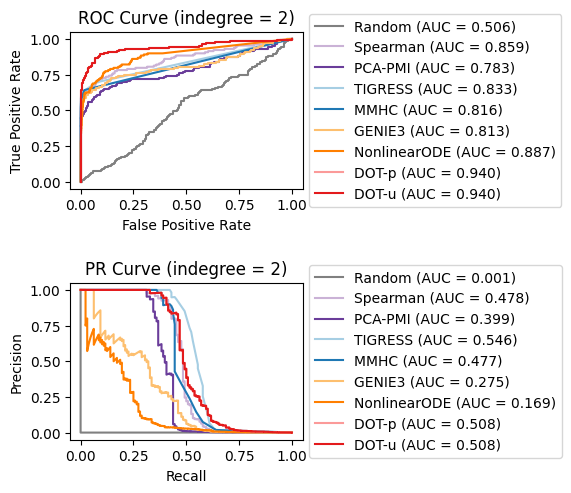

Indegrees:  33%|███▎      | 1/3 [3:30:35<7:01:10, 12635.47s/it]

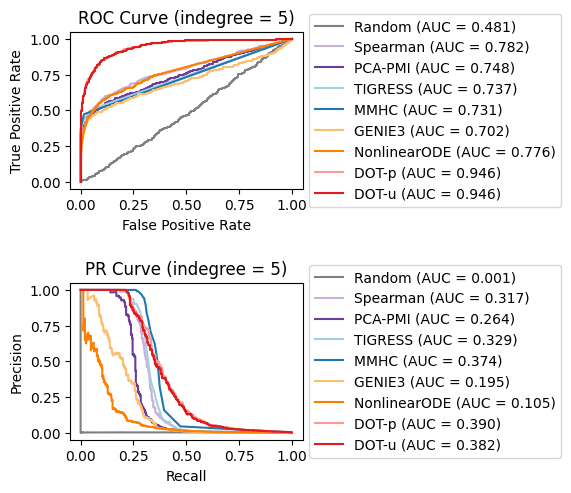

Indegrees:  67%|██████▋   | 2/3 [5:41:40<2:43:49, 9829.25s/it] 

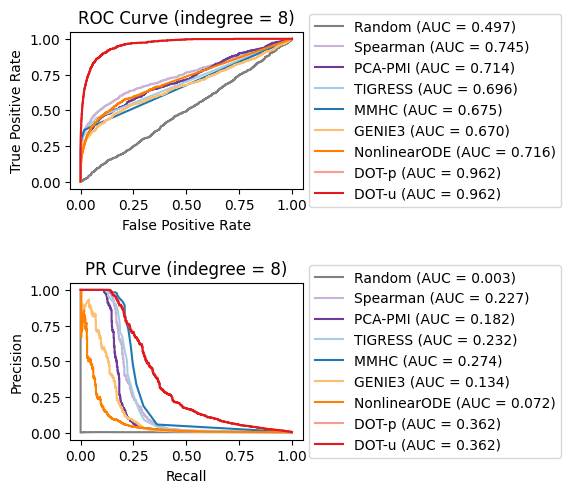

Indegrees: 100%|██████████| 3/3 [7:53:56<00:00, 9478.76s/it]  


In [4]:
# Begin simulation
auroc_list = np.zeros((len(indegrees), len(methods), n_replicates))  # indegrees * methods * replicates
aupr_list = np.zeros((len(indegrees), len(methods), n_replicates))
ep_list = np.zeros((len(indegrees), len(methods), n_replicates))

for jj, indegree in enumerate(tqdm(indegrees, desc='Indegrees', leave=True, position=0)):
    for i_repl in tqdm(range(n_replicates), desc='Replicates', leave=True, position=1):
        np.random.seed(int(123 + indegree*10 + i_repl))
        
        # Generate simulated data
        exp1 = generate_multinormal_matrix(n_sample, n_gene).T
        exp2, true_plan = generate_paired_matrix(exp1, diffgene, indegree, snr=2)
        
        y_true = true_plan.copy()
        y_true[y_true!=0] = 1
        
        top_num = int(np.sum(y_true[mask] == 1))

        # Normalize expression matrices
        exp1 = normalize_expression_matrix(exp1)
        exp2 = normalize_expression_matrix(exp2)

        # Perform differential expression analysis
        diff_idx = different_expression_analysis(exp1, exp2, alpha=0.05)
        exp1_diff = exp1[diff_idx]
        exp2_diff = exp2[diff_idx]
        
        # Suffle exp2 to construct unpaired samples
        perm = np.random.permutation(n_sample)
        exp2_unpair = exp2[:, perm]
        
        # Baseline: Random
        random = np.random.permutation(np.arange(n_gene*n_gene)).reshape(n_gene, n_gene).astype(np.float64)
        random /= np.max(random)
        
        # Competing method: Spearman
        cor = np.abs(spearman_correlation(exp1, exp2))
        
        # Competing method: PCA-PMI
        if n_gene > 1000 and n_sample < 100:
            pmi = method_pcapmi(exp1_diff, exp2_diff)
            pmi = diff2all_matrix(pmi, diff_idx, n_gene)
        else:
            pmi = method_pcapmi(exp1, exp2)

        # Competing methods: TIGRESS, MMHC, GENIE3, NonlinearODE
        methods_temp = {
            'tigress': method_tigress,
            'mmhc': method_mmhc,
            'genie3': method_genie3,
            'nonlinearODE': method_nonlinearODE
        }
        
        results = {}
        for name, method in methods_temp.items():
            results[name] = implement_method(method, exp1, exp2, exp1_diff, exp2_diff, diff_idx, n_gene)

        tigress = results['tigress']
        mmhc = results['mmhc']
        genie3 = results['genie3']
        nonlinearODE = results['nonlinearODE']

        # Proposed method: Double OT
        dot_p = double_ot(exp1, exp2, paired = True)
        dot_u = double_ot(exp1, exp2, paired = False)

        # Combine the score matrices
        y_scores = [random, cor, pmi, tigress, mmhc, genie3, nonlinearODE, dot_p, dot_u]
        
        # Plot ROC and PR curves
        if i_repl == n_replicates - 1:
            plot_roc_pr_curves(y_true, y_scores, mask, methods, colors, indegree)
        
        # Evaluate the score matrices
        for ii, _ in enumerate(methods):
            auroc, aupr = auroc_aupr(y_true, y_scores[ii], mask)
            ep = early_precision(y_true, y_scores[ii], mask, top_num)
            auroc_list[jj, ii, i_repl] = auroc
            aupr_list[jj, ii, i_repl] = aupr
            ep_list[jj, ii, i_repl] = ep

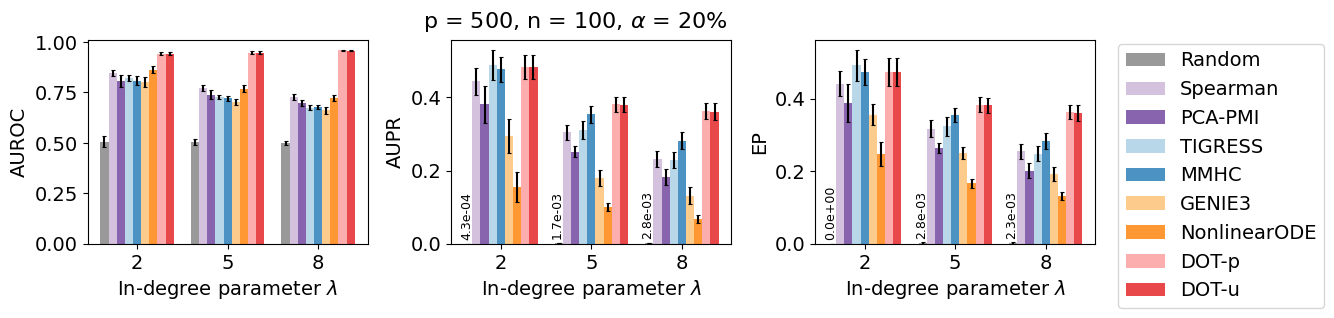

In [5]:
# Plot AUROC, AUPR, and EP bar charts
plot_bar_charts(auroc_list, aupr_list, ep_list, indegrees, methods, colors, n_gene, n_sample, diffgene)